In [1]:
import kooplearn
import kooplearn.datasets
import matplotlib.pyplot as plt


In [2]:
import logging
import math
from pathlib import Path
from typing import Optional

import numpy as np
import scipy
import scipy.sparse
from scipy.integrate import romb
from scipy.special import binom
from scipy.stats.sampling import NumericalInversePolynomial

from kooplearn._src.utils import topk
from kooplearn.datasets.misc import (
    DataGenerator,
    DiscreteTimeDynamics,
    LinalgDecomposition,
)
import tqdm

from kooplearn.datasets.stochastic import LangevinTripleWell1D
class LangevinTripleWell1D(DiscreteTimeDynamics):
    def __init__(
        self,
        gamma: float = 0.1,
        kt: float = 1.0,
        dt: float = 1e-4,
        rng_seed: Optional[int] = None,
        height=0.1,
        sigma=0.05,
        freq=500
    ):
        self.gamma = gamma
        self.kt = kt
        self.rng = np.random.default_rng(rng_seed)
        self.dt = dt

        self._inv_gamma = (self.gamma) ** -1
        self.list_centers = []
        self.height = height
        self.sigma = sigma
        self.freq = freq
    def sample(self, X0: np.ndarray, T: int = 1, show_progress: bool = False):
        X0 = np.asarray(X0)
        
        if X0.ndim == 0:
            X0 = X0[None]

        memory = np.zeros((T + 1,) + X0.shape)
        meta_forces = np.zeros((T + 1,) + X0.shape)
        forces = np.zeros((T + 1,) + X0.shape)
        memory[0] = X0
        show_progress = True
        if show_progress:
            _iter = tqdm.tqdm(range(T), desc="Generating data", unit="step", leave=False)
        else:
            _iter = range(T)

        for t in _iter:
            if t% self.freq ==0 and t !=0:
                self.list_centers.append(memory[t])
            memory[t + 1], forces[t+1], meta_forces[t + 1] = self._step(memory[t])
        return memory, forces, meta_forces
    def eig(self):
        if not hasattr(self, "_ref_evd"):
            self._compute_ref_evd()
        return self._ref_evd
    def _compute_ref_evd(self):
        assets_path = Path(__file__).parent / "assets"

        lap_x = scipy.sparse.load_npz(assets_path / "1D_triple_well_lap_x.npz")
        grad_x = scipy.sparse.load_npz(assets_path / "1D_triple_well_grad_x.npz")
        cc = np.load(assets_path / "1D_triple_well_cc.npz")

        force = scipy.sparse.diags(self.force_fn(cc))

        # Eq.(31) of https://doi.org/10.1007/978-3-642-56589-2_9 recalling that \sigma^2/(\gamma*2) = kBT
        generator = self._inv_gamma * self.kt * lap_x + self._inv_gamma * force.dot(
            grad_x
        )
        generator = generator * self.dt

        vals, vecs = np.linalg.eig(generator.toarray())

        # Filter out timescales smaller than dt
        mask = np.abs(vals.real) < 1.0
        vals = vals[mask]
        vecs = vecs[:, mask]

        vals = np.exp(vals)
        # Checking that the eigenvalues are real
        type_ = vals.dtype.type
        f = np.finfo(type_).eps

        tol = f * 1000
        if not np.all(np.abs(vals.imag) < tol):
            raise ValueError(
                "The computed eigenvalues are not real, try to decrease dt"
            )
        else:
            vals = vals.real

        _k = len(vals)
        evd_sorting_perm = topk(vals, _k)
        vals = evd_sorting_perm.values
        vecs = vecs[:, evd_sorting_perm.indices].real

        dx = cc[1] - cc[0]
        boltzmann_pdf = (dx**-1) * scipy.special.softmax(self.force_fn(cc) / self.kt)
        abs2_eigfun = (np.abs(vecs) ** 2).T
        eigfuns_norms = np.sqrt(romb(boltzmann_pdf * abs2_eigfun, dx=dx, axis=-1))
        vecs = vecs * (eigfuns_norms**-1.0)

        # Storing the results
        self._ref_evd = LinalgDecomposition(vals, cc, vecs)
        self._ref_boltzmann_density = boltzmann_pdf

    def _step(self, X: np.ndarray):
        F, bias = self.force_fn(X)
        xi = self.rng.standard_normal(X.shape)
        dX = (
            F * self._inv_gamma * self.dt
            + np.sqrt(2.0 * self.kt * self.dt * self._inv_gamma) * xi
        )
        return X + dX, F, bias
    def meta_force(self,x):
        return  ((x - np.array(self.list_centers)) * self.height * np.exp( - ( x - np.array(self.list_centers))**2 / (2 * self.sigma **2))).sum() / (self.sigma**2)
    def force_fn(self, x: np.ndarray):
        bias = 0
        f_four = -4*( 8*x**7- 0.8*80*2*x*np.exp(-80*(x**2)) -  0.2**80*(x-0.5)*2*np.exp(-80*((x - 0.5)**2)) - 0.5*40*(x+0.5)*2*np.exp(-40*((x + 0.5)**2)))
        
        f_two = -  32 *x **7  +4*80*0.8*2 *np.exp(-80*x**2)*x
        return f_two, f_two-f_four #-8*(x-1)*(x+1)**2 - 8*(x-1)**2*(x+1)


In [270]:
langevin = LangevinTripleWell1D(rng_seed=0,gamma=2.0,dt=1e-4,height=0.05,sigma=0.1,freq=2000,kt=1.0) #sigma=0.1

In [271]:
sample,forces, meta_forces = langevin.sample(1.0, 2_000_000)

Generating data:   0%|          | 16257/4000000 [00:01<04:31, 14680.18step/s]

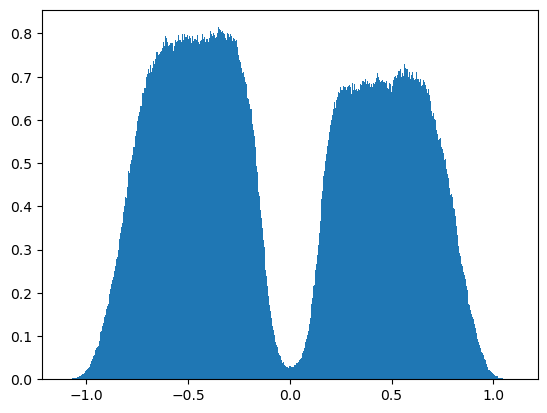

In [272]:
import matplotlib.pyplot as plt
plt.hist(sample, bins=500, density=True);

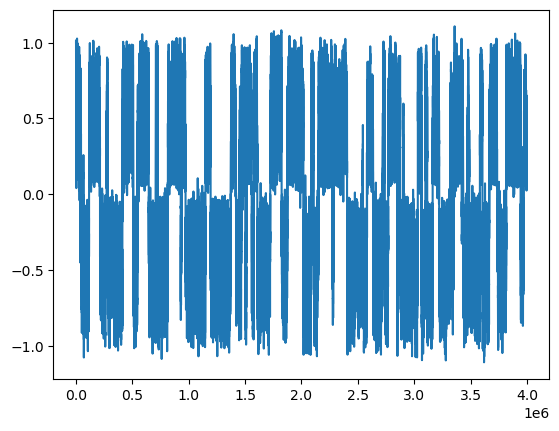

In [273]:
plt.plot(sample)


In [322]:
from sklearn.gaussian_process.kernels import RBF
from kooplearn.data import traj_to_contexts
#0.2 1e-2 1000 PCR
kernel = RBF(length_scale=0.175) #0.65 works  well #0.4 best
model = kooplearn.models.kernel.KernelGenerator(kernel, reduced_rank=False, rank=8
                                   
                                   , tikhonov_reg=1e-5
                                   )

In [323]:
def force(x):
    return -40*x*(x**2-1)

test=sample[::500]
train_data = traj_to_contexts(test)
forces_train = traj_to_contexts(forces[::500])
train_data.shape
bias = traj_to_contexts(meta_forces[::500])
print(bias.shape)

(2000, 2, 1)


In [324]:
model = model.fit(train_data,forces=(forces_train-bias)/2.0,friction=2*1.0/2.0) #np.sqrt(2))


Fitted KernelGenerator model. Lookback length set to 1


In [325]:
vals_gen,vecs_gen = model.eig(eval_right_on=train_data[:,:1, ...])

In [326]:
print(vals_gen)



[-114.88761658+0.j -110.46052054+0.j  -72.50625284+0.j  -66.34895848+0.j
  -46.37681872+0.j  -36.57573134+0.j  -11.36478055+0.j   -2.55122704+0.j
   -0.46377783+0.j   -0.12552696+0.j]


###### 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(array([], dtype=int64),)


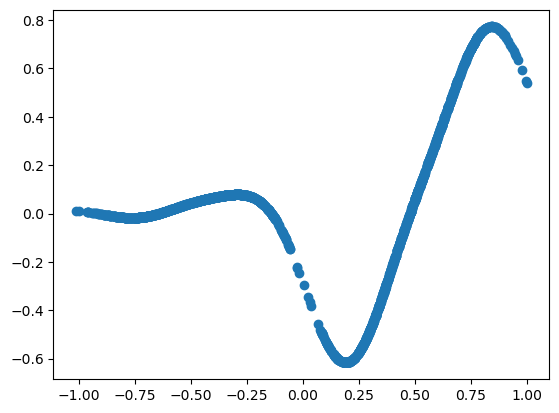

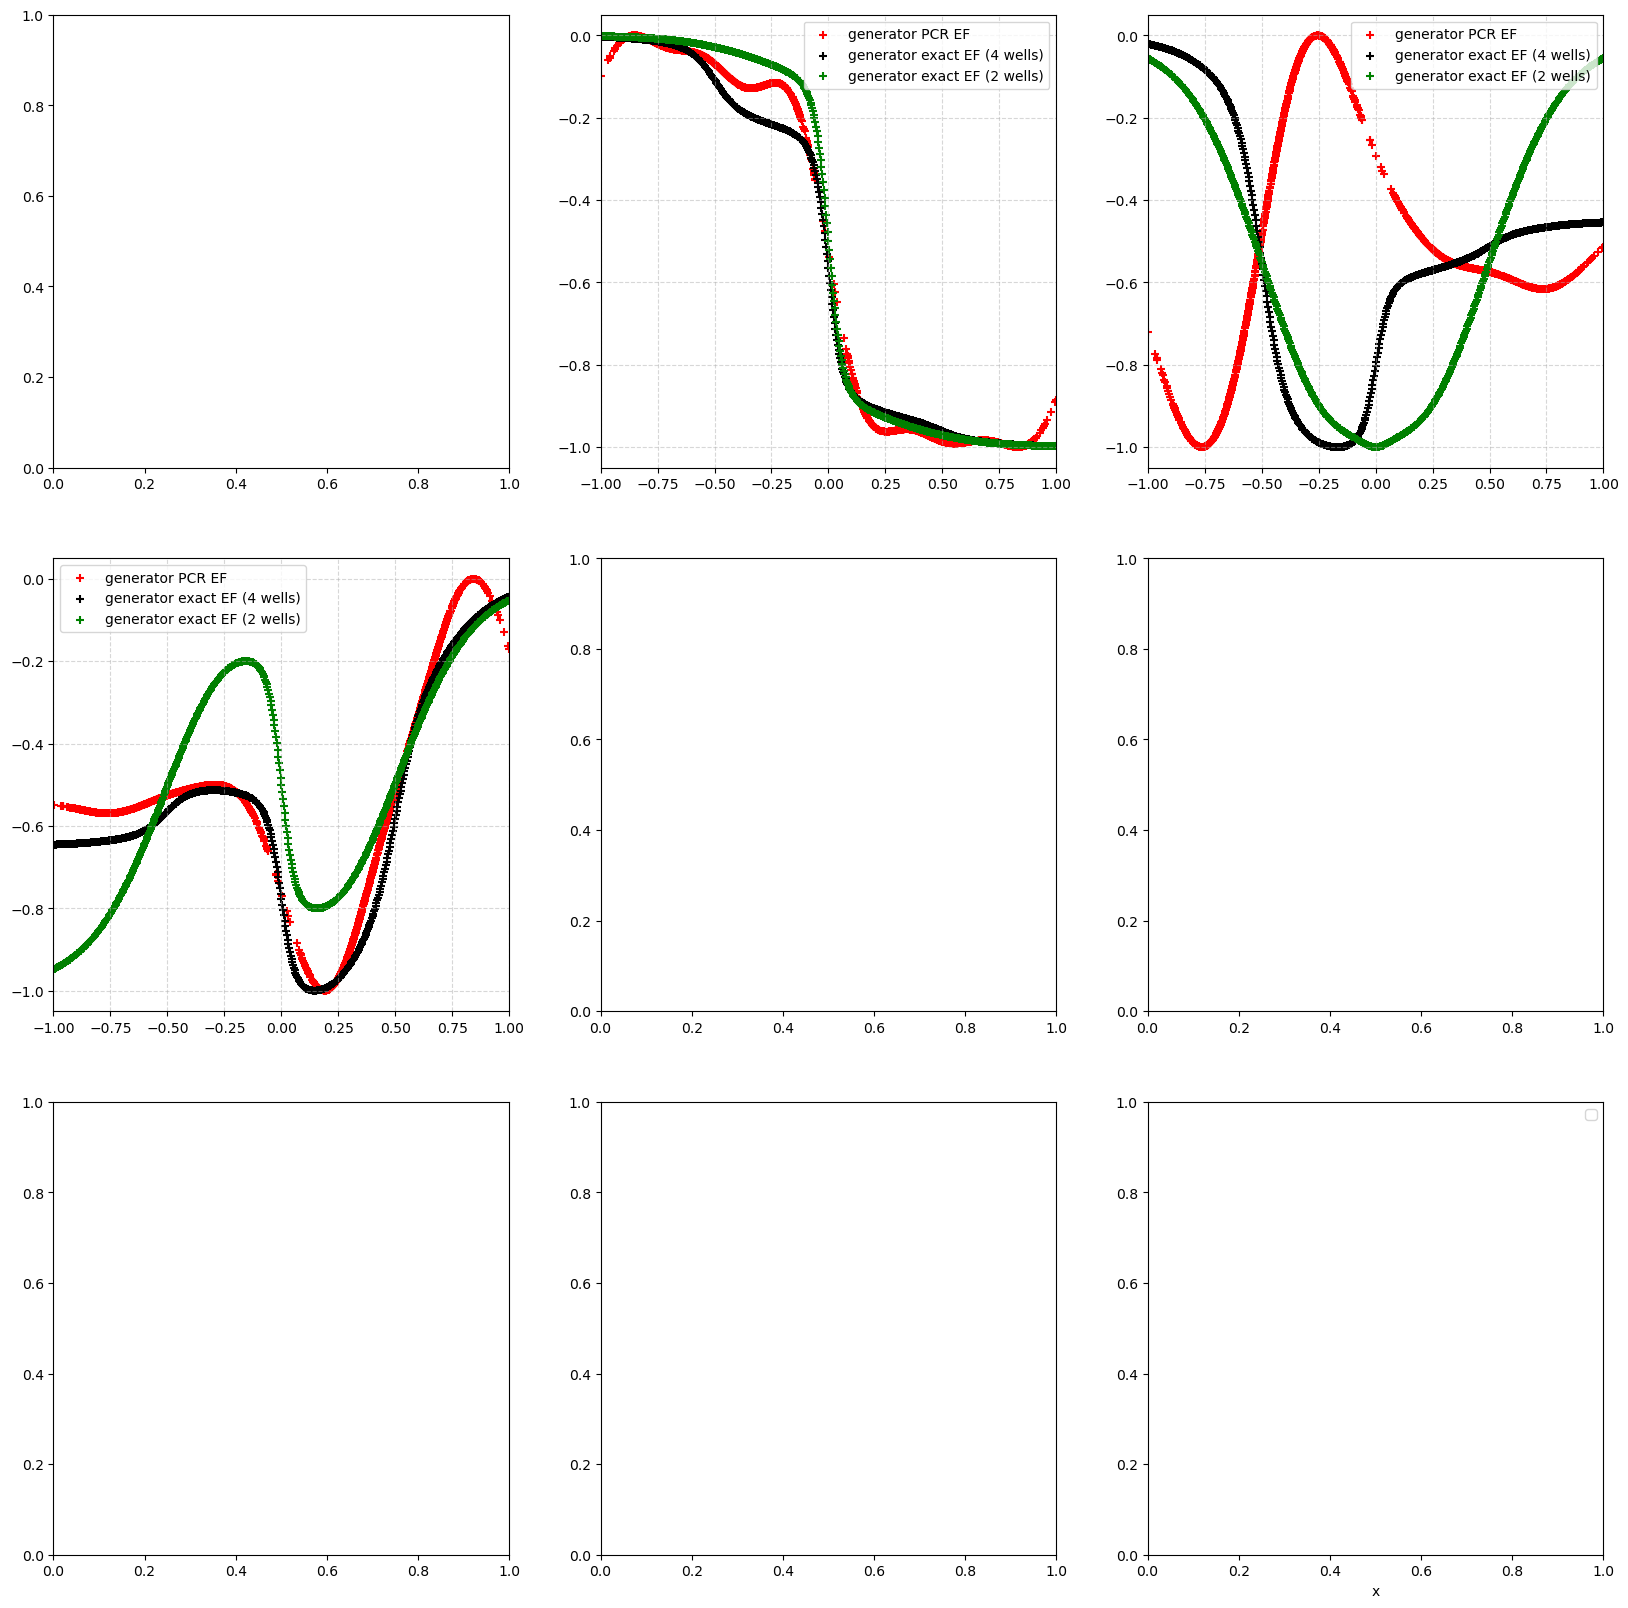

In [327]:
import numpy as np
from scipy.integrate import solve_bvp
import matplotlib.pyplot as plt




solutions4 =np.load("/home/tdevergne@iit.local/Documents/eigenfunctions_four.np",allow_pickle=True)
x_values4  =np.load("/home/tdevergne@iit.local/Documents/centers_four.np",allow_pickle=True)
solutions2 =np.load("/home/tdevergne@iit.local/Documents/eigenfunctions_two.np",allow_pickle=True)
x_values2  =np.load("/home/tdevergne@iit.local/Documents/centers_two.np",allow_pickle=True)
plt.scatter(np.squeeze(train_data[:,:1, ...]),vecs_gen[:,-4],label="PCR generator first eigenfunction")
#plt.scatter(np.squeeze(train_data[:,:1, ...]), vecs[:,-2],label="PCR transfer first eigenfunction")
#plt.plot(decomp.x[values],-funcs[values,2],label="exact eigenfunction",color="r")

plt.plot()
num = 3
fig, axes = plt.subplots(num, num, figsize=(20, 20))
#values = np.where(np.logical_and(decomp.x>-1,decomp.x<1))[0]
print(np.where(vecs_gen[:,-1]==0))

new_0 = -(vecs_gen[:,-1]-vecs_gen[:,-1].min())/(vecs_gen[:,-1].min()-vecs_gen[:,-1].max())

for i in range(1,4):
    #vecs_gen[:,-i-1] /= vecs_gen[:,-1]
    #vecs_gen[:,-i-1] /= vecs_gen[:,-1]
    new_gen = (vecs_gen[:,-i-1]-vecs_gen[:,-i-1].min())/(vecs_gen[:,-i-1].min()-vecs_gen[:,-i-1].max())
    new_sol4 = (solutions4[:,i]-solutions4[:,i].min())/(solutions4[:,i].min()-solutions4[:,i].max())
    new_sol2 = (solutions2[:,i]-solutions2[:,i].min())/(solutions2[:,i].min()-solutions2[:,i].max())
    if i ==1 or i==3 :
        axes[i//num, i%num].scatter(np.squeeze(train_data[:,:1, ...]), -new_gen-1, marker="+", color='r',label="generator PCR EF")

    else:
        axes[i//num, i%num].scatter(np.squeeze(train_data[:,:1, ...]), new_gen, marker="+", color='r',label="generator PCR EF")
    axes[i//num, i%num].scatter(x_values4,new_sol4, marker="+", color='k', label="generator exact EF (4 wells)")
    axes[i//num, i%num].scatter(x_values2,new_sol2, marker="+", color='g', label="generator exact EF (2 wells)")
    axes[i//num, i%num].grid(True, linestyle='--', alpha=.5)
    axes[i//num, i%num].set_xlim(-1, 1)
    #axes[i//num, i%num].set_ylim(y_min, y_max)

    axes[i//num, i%num].legend()

plt.xlabel('x')
#plt.ylabel('')
plt.legend()
plt.show()

ValueError: x and y must be the same size

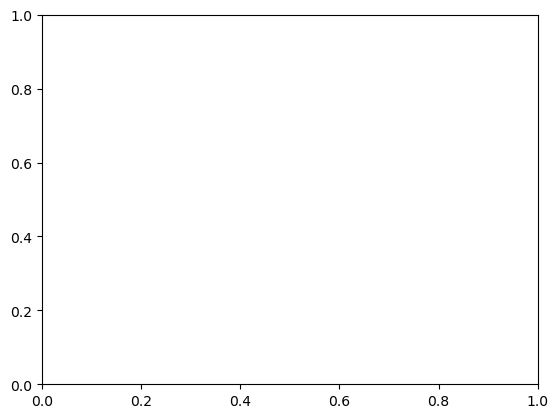

In [328]:
plt.scatter(x_values,test,label="analytical solution ef 0")
plt.scatter(x_values,test1,label="analytical solution ef 1")
plt.legend()
